In [108]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dipole

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield, lf3d, j3d
from mhsflex.vis import plot, plot_plasma_parameters
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt

from mflex.model.field.utility.poloidal import (
    phi,
    phi_low,
    phi_hypgeo,
    dphidz_hypgeo,
    dphidz,
    dphidz_low,
)

rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

In [121]:
nresol_x = 400
nresol_y = 400
nresol_z = 400
xmin = 0.0
xmax = 20.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 20.0
zmin = 0.0
zmax = 20.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 2.0

nf_max = 180

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
B_PHOTO = 500
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dipole(x, y) * B_PHOTO

In [122]:
data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nresol_x,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

data2d.nf = nf_max

In [123]:
a = 0.44
alpha = 0.05
b = 1.0
z0 = 2.0

In [124]:
length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * data2d.px
length_scale_y = 2.0 * nresol_y * data2d.py

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(data2d.nf) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(data2d.nf) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(data2d.nf) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[1, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[0, 1] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2

# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - alpha**2) / (2 * k2_arr)

print(limit.min(), limit.argmin())

0.47466970408941556 0


In [125]:
folder = "/Users/lilli/Desktop/Thesis/deltaz_test_neu"

In [126]:
deltaz_list = list([0.2])

for deltaz in deltaz_list:

    phi_asymp = np.zeros((nf_max, nf_max, nresol_z))
    dphidz_asymp = np.zeros((nf_max, nf_max, nresol_z))

    p_arr = 0.5 * deltaz * np.sqrt(k2_arr * (1.0 - a - a * b) - alpha**2)
    q_arr = 0.5 * deltaz * np.sqrt(k2_arr * (1.0 - a + a * b) - alpha**2)

    for iz, z in enumerate(z_arr):
        phi_asymp[:, :, iz] = phi(z, p_arr, q_arr, z0, deltaz)
        dphidz_asymp[:, :, iz] = dphidz(z, p_arr, q_arr, z0, deltaz)
        # phi_hyper[:, :, iz] = phi_hypgeo(z, p_arr, q_arr, z0, deltaz)
        # dphidz_hyper[:, :, iz] = dphidz_hypgeo(z, p_arr, q_arr, z0, deltaz)

In [127]:
for deltaz in deltaz_list:

    phi_hyper = np.zeros((nf_max, nf_max, nresol_z))
    dphidz_hyper = np.zeros((nf_max, nf_max, nresol_z))

    p_arr = 0.5 * deltaz * np.sqrt(k2_arr * (1.0 - a - a * b) - alpha**2)
    q_arr = 0.5 * deltaz * np.sqrt(k2_arr * (1.0 - a + a * b) - alpha**2)

    for iz, z in enumerate(z_arr):

        phi_hyper[:, :, iz] = phi_hypgeo(z, p_arr, q_arr, z0, deltaz)
        dphidz_hyper[:, :, iz] = dphidz_hypgeo(z, p_arr, q_arr, z0, deltaz)

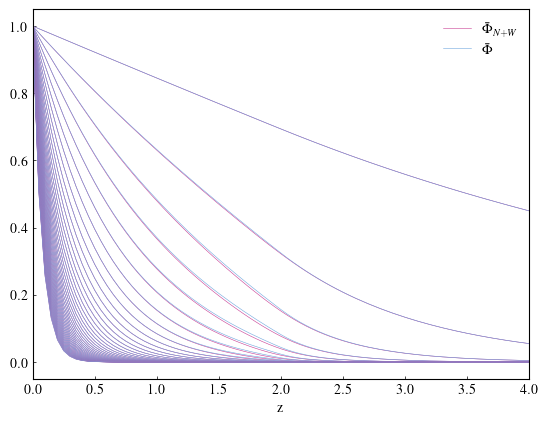

In [128]:
c4 = (0.784, 0.231, 0.576)

c2 = (0.435, 0.651, 0.871)

for ix in range(4, nf_max, 4):
    plt.plot(
        z_arr,
        phi_hyper[ix, ix, :],
        linewidth=0.4,
        color=c4,
        # label="N+W (2019)"
    )
    plt.plot(
        z_arr,
        phi_asymp[ix, ix, :],
        linewidth=0.4,
        color=c2,
        # label="N+N (2024)",
    )
plt.plot(
    z_arr,
    phi_hyper[0, 0, :],
    linewidth=0.4,
    color=c4,
    label=r"$\bar\Phi_{N+W}$",
)
plt.plot(
    z_arr,
    phi_asymp[0, 0, :],
    linewidth=0.4,
    color=c2,
    label=r"$\bar\Phi$",
)
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.xlabel("z")
# plt.ylabel(r"$\bar{\Phi}$")
plotname = (
    folder + "/phi_faecher_" + str(alpha) + "_" + str(a) + "_" + str(deltaz) + ".png"
)
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

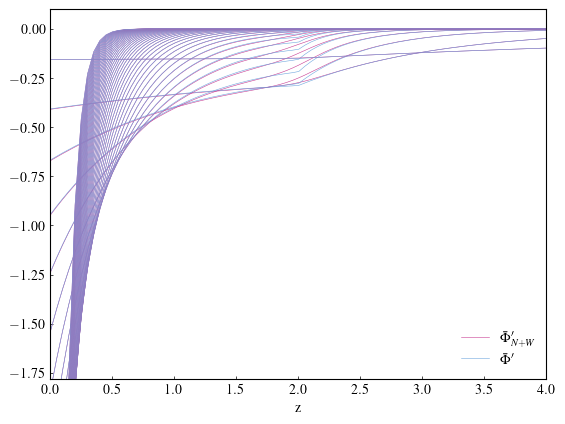

In [129]:
for ix in range(4, nf_max, 4):
    plt.plot(
        z_arr,
        dphidz_hyper[ix, ix, :],
        linewidth=0.4,
        color=c4,
        # label="N+W (2019)"
    )
    plt.plot(
        z_arr,
        dphidz_asymp[ix, ix, :],
        linewidth=0.4,
        color=c2,
        # label="N+N (2024)",
    )

plt.plot(
    z_arr,
    dphidz_hyper[0, 0, :],
    linewidth=0.4,
    color=c4,
    label=r"$\bar\Phi_{N+W}'$",
)
plt.plot(
    z_arr,
    dphidz_asymp[0, 0, :],
    linewidth=0.4,
    color=c2,
    label=r"$\bar\Phi'$",
)
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.xlabel("z")
plotname = (
    folder + "/dphidz_faecher_" + str(alpha) + "_" + str(a) + "_" + str(deltaz) + ".png"
)
plt.ylim([-1.78, 0.1])
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [130]:
abserrphi = np.zeros_like(phi_asymp)
abserrdphi = np.zeros_like(phi_asymp)
relerrphi = np.zeros_like(phi_asymp)
relerrdphi = np.zeros_like(phi_asymp)

In [131]:
for ix in range(nf_max):
    for iy in range(nf_max):
        for iz in range(nresol_z):

            abserrphi[iy, ix, iz] = abs(phi_hyper[iy, ix, iz] - phi_asymp[iy, ix, iz])
            abserrdphi[iy, ix, iz] = abs(
                dphidz_hyper[iy, ix, iz] - dphidz_asymp[iy, ix, iz]
            )
            relerrphi[iy, ix, iz] = abs(
                phi_hyper[iy, ix, iz] - phi_asymp[iy, ix, iz]
            ) / abs(phi_asymp[iy, ix, iz])
            relerrdphi[iy, ix, iz] = abs(
                dphidz_hyper[iy, ix, iz] - dphidz_asymp[iy, ix, iz]
            ) / abs(dphidz_asymp[iy, ix, iz])

In [132]:
abserrphi_max = np.zeros_like(z_arr)
abserrphi_min = np.zeros_like(z_arr)

abserrdphi_max = np.zeros_like(z_arr)
abserrdphi_min = np.zeros_like(z_arr)

relerrphi_max = np.zeros_like(z_arr)
relerrphi_min = np.zeros_like(z_arr)

relerrdphi_max = np.zeros_like(z_arr)
relerrdphi_min = np.zeros_like(z_arr)

In [133]:
for iz in range(nresol_z):

    abserrphi_max[iz] = abserrphi[:, :, iz].max()
    abserrphi_min[iz] = abserrphi[:, :, iz].min()

    abserrdphi_max[iz] = abserrdphi[:, :, iz].max()
    abserrdphi_min[iz] = abserrdphi[:, :, iz].min()

    relerrphi_max[iz] = relerrphi[:, :, iz].max()
    relerrphi_min[iz] = relerrphi[:, :, iz].min()

    relerrdphi_max[iz] = relerrdphi[:, :, iz].max()
    relerrdphi_min[iz] = relerrdphi[:, :, iz].min()

In [134]:
abserrphi_surf = np.zeros((nf_max, nf_max))
relerrphi_surf = np.zeros_like(abserrphi_surf)

In [135]:
for ix in range(nf_max):
    for iy in range(nf_max):
        abserrphi_surf[iy, ix] = abserrphi[iy, ix, :].max()
        relerrphi_surf[iy, ix] = relerrphi[iy, ix, :].max()

In [136]:
errormap = colors.LinearSegmentedColormap.from_list(
    "my_gradient",
    (
        # Edit this gradient at https://eltos.github.io/gradient/#FFFDFD-4B4B4B
        (0.000, (1.000, 1.0, 1.0)),
        (1.000, (0.435, 0.651, 0.871)),
    ),
)

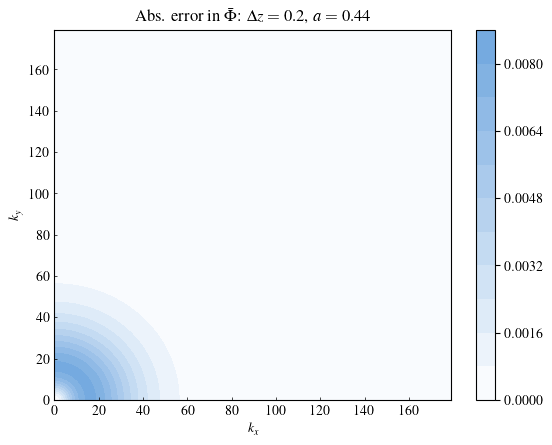

In [143]:
plt.contourf(abserrphi_surf, levels=10, cmap=errormap)
plt.colorbar()
# plt.legend()
plt.xlabel(r"$k_x$")
plt.ylabel(r"$k_y$")
# plt.ylabel(r"$| \overline{\Phi}_{N+W} - \overline{\Phi} | $")
plotname = (
    folder + "/phi_ae_fm_" + str(alpha) + "_" + str(a) + "_" + str(deltaz) + ".png"
)
plt.title(
    r"Abs. error in $\bar{\Phi}$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a)
)
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

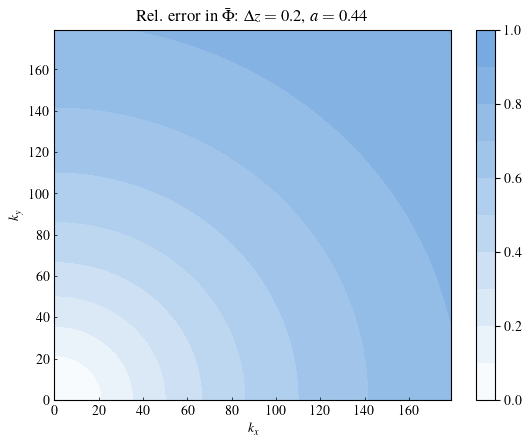

In [144]:
plt.contourf(relerrphi_surf, levels=10, cmap=errormap)
plt.colorbar()
# plt.legend()
plt.xlabel(r"$k_x$")
plt.ylabel(r"$k_y$")
# plt.ylabel(r"$| \overline{\Phi}_{N+W} - \overline{\Phi} | $")
plotname = (
    folder + "/phi_re_fm_" + str(alpha) + "_" + str(a) + "_" + str(deltaz) + ".png"
)
plt.title(
    r"Rel. error in $\bar{\Phi}$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a)
)
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [149]:
abserrdphi_surf = np.zeros((nf_max, nf_max))
relerrdphi_surf = np.zeros((nf_max, nf_max))

for ix in range(nf_max):
    for iy in range(nf_max):
        abserrdphi_surf[iy, ix] = abserrdphi[iy, ix, :].max()
        relerrdphi_surf[iy, ix] = relerrdphi[iy, ix, :].max()

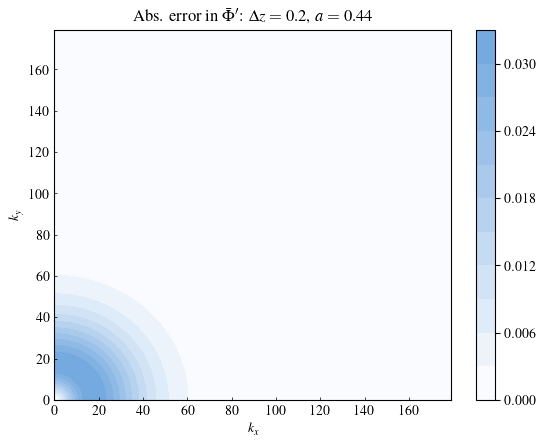

In [150]:
plt.contourf(abserrdphi_surf, levels=10, cmap=errormap)
plt.colorbar()
# plt.legend()
plt.xlabel(r"$k_x$")
plt.ylabel(r"$k_y$")
# plt.ylabel(r"$| \overline{\Phi}_{N+W} - \overline{\Phi} | $")
plotname = (
    folder + "/dphi_ae_fm_" + str(alpha) + "_" + str(a) + "_" + str(deltaz) + ".png"
)
plt.title(
    r"Abs. error in $\bar{\Phi}'$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a)
)
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

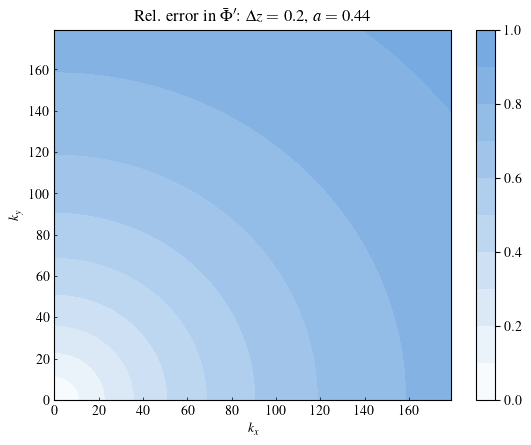

In [151]:
plt.contourf(relerrdphi_surf, levels=10, cmap=errormap)
plt.colorbar()
# plt.legend()
plt.xlabel(r"$k_x$")
plt.ylabel(r"$k_y$")
plt.title(
    r"Rel. error in $\bar{\Phi}'$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a)
)
# plt.ylabel(r"$| \overline{\Phi}_{N+W} - \overline{\Phi} | $")
plotname = (
    folder + "/dphi_re_fm_" + str(alpha) + "_" + str(a) + "_" + str(deltaz) + ".png"
)
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
np.unravel_index(abserrphi.argmax(), abserrphi.shape)

# np.unravel_index(abserrdphi.argmax(), abserrdphi.shape)

In [152]:
meanerror = np.mean(abserrphi, axis=(0, 1))
std = np.std(abserrphi, axis=(0, 1))

meanerrordp = np.mean(abserrdphi, axis=(0, 1))
stddp = np.std(abserrdphi, axis=(0, 1))

meanerrorr = np.mean(relerrphi, axis=(0, 1))
stdr = np.std(relerrphi, axis=(0, 1))

meanerrordpr = np.mean(relerrdphi, axis=(0, 1))
stddpr = np.std(relerrdphi, axis=(0, 1))

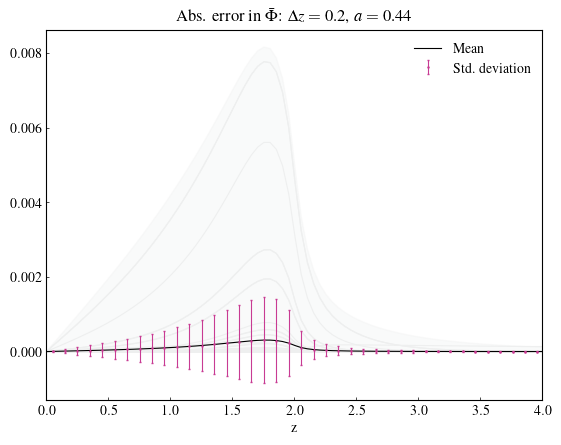

In [155]:
plt.fill_between(
    data2d.z, abserrphi_min, abserrphi_max, color=(0.933, 0.937, 0.937), alpha=0.3
)
for ix in range(0, nf_max, 20):
    for iy in range(0, nf_max, 20):
        plt.plot(
            z_arr,
            abserrphi[iy, ix, :],
            linewidth=0.8,
            color=(0.933, 0.937, 0.937),
            # alpha=0.5
        )
plt.plot(z_arr, meanerror, linewidth=0.8, color="black", label="Mean")
plt.errorbar(
    z_arr[np.arange(1, len(meanerrordpr), 2)],
    meanerror[np.arange(1, len(meanerrordpr), 2)],
    std[np.arange(1, len(meanerrordpr), 2)],
    marker="o",
    markersize=0.8,
    linestyle="None",
    linewidth=0.8,
    color=(0.784, 0.231, 0.576),
    capsize=0.8,
    label="Std. deviation",
)

plt.xlim([0, 2 * z0])
# plt.legend()
plt.xlabel("z")
# plt.ylabel(r"Abs. error $\bar{\Phi}$")
plt.title(
    r"Abs. error in $\bar{\Phi}$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a)
)
plotname = (
    folder + "/phi_abserr1_" + str(alpha) + "_" + str(a) + "_" + str(deltaz) + ".png"
)
plt.tick_params(direction="in", length=2, width=0.5)
plt.legend(frameon=False)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

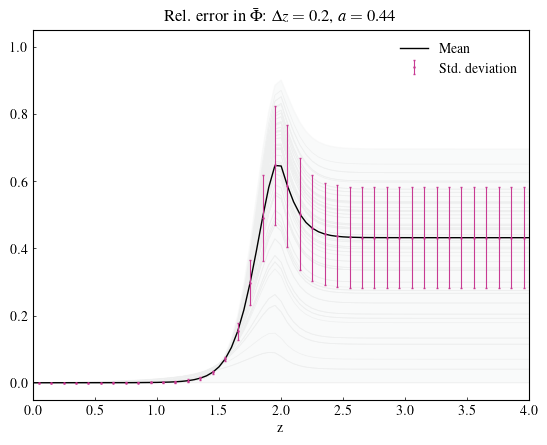

In [157]:
plt.fill_between(
    data2d.z, relerrphi_min, relerrphi_max, color=(0.933, 0.937, 0.937), alpha=0.3
)
for ix in range(0, nf_max, 20):
    for iy in range(0, nf_max, 20):
        plt.plot(
            z_arr,
            relerrphi[iy, ix, :],
            linewidth=0.5,
            color=(0.933, 0.937, 0.937),
            # alpha=0.5
        )
plt.plot(z_arr, meanerrorr, linewidth=1.0, color="black", label="Mean")
plt.errorbar(
    z_arr[np.arange(1, len(meanerrordpr), 2)],
    meanerrorr[np.arange(1, len(meanerrordpr), 2)],
    stdr[np.arange(1, len(meanerrordpr), 2)],
    linestyle="None",
    marker="o",
    markersize=0.8,
    linewidth=0.8,
    color=(0.784, 0.231, 0.576),
    capsize=0.8,
    label="Std. deviation",
)

plt.xlim([0, 2 * z0])
# plt.legend()
plt.xlabel("z")
#plt.ylabel(r"Rel. error $\bar{\Phi}$")
plt.title(r"Rel. error in $\bar{\Phi}$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a))
plotname = (
    folder + "/dphi_relerr1_" + str(alpha) + "_" + str(a) + "_" + str(deltaz) + ".png"
)
plt.tick_params(direction="in", length=2, width=0.5)
plt.legend(frameon=False)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

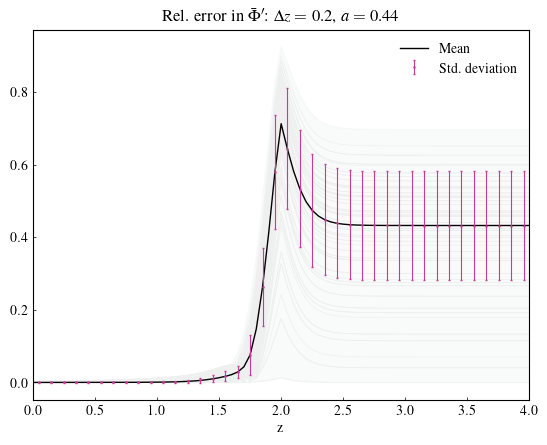

In [158]:
plt.fill_between(
    data2d.z, relerrdphi_min, relerrdphi_max, color=(0.933, 0.937, 0.937), alpha=0.3
)
for ix in range(0, nf_max, 20):
    for iy in range(0, nf_max, 20):
        plt.plot(
            z_arr,
            relerrdphi[iy, ix, :],
            linewidth=0.5,
            color=(0.933, 0.937, 0.937),
            # alpha=0.5
        )
plt.plot(z_arr, meanerrordpr, linewidth=1.0, color="black", label="Mean")
plt.errorbar(
    z_arr[np.arange(1, len(meanerrordpr), 2)],
    meanerrordpr[np.arange(1, len(meanerrordpr), 2)],
    stddpr[np.arange(1, len(meanerrordpr), 2)],
    linestyle="None",
    marker="o",
    markersize=0.8,
    linewidth=0.8,
    color=(0.784, 0.231, 0.576),
    capsize=0.8,
    label="Std. deviation",
)

plt.xlim([0, 2 * z0])
# plt.legend()
plt.xlabel("z")
#plt.ylabel(r"Rel. error $\bar{\Phi}'$")
plt.title(r"Rel. error in $\bar{\Phi}'$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a))
plotname = (
    folder + "/phi_relerr1_" + str(alpha) + "_" + str(a) + "_" + str(deltaz) + ".png"
)
plt.tick_params(direction="in", length=2, width=0.5)
plt.legend(frameon=False)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

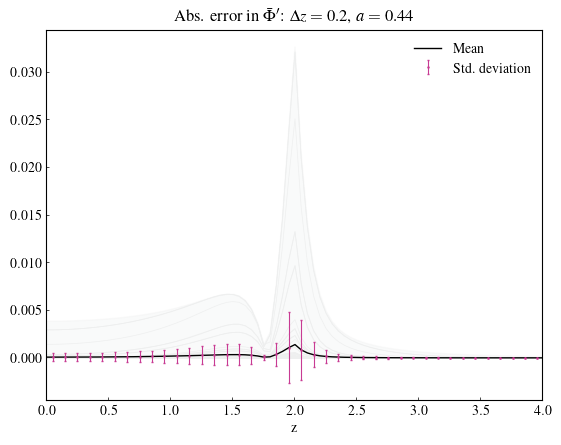

In [159]:
plt.fill_between(
    data2d.z, abserrdphi_min, abserrdphi_max, color=(0.933, 0.937, 0.937), alpha=0.3
)
for ix in range(0, nf_max, 20):
    for iy in range(0, nf_max, 20):
        plt.plot(
            z_arr,
            abserrdphi[iy, ix, :],
            linewidth=0.5,
            color=(0.933, 0.937, 0.937),
            # alpha=0.5
        )
plt.plot(z_arr, meanerrordp, linewidth=1.0, color="black", label="Mean")
plt.errorbar(
    z_arr[np.arange(1, len(meanerrordpr), 2)],
    meanerrordp[np.arange(1, len(meanerrordpr), 2)],
    stddp[np.arange(1, len(meanerrordpr), 2)],
    linestyle="None",
    marker="o",
    markersize=0.8,
    linewidth=0.8,
    color=(0.784, 0.231, 0.576),
    capsize=0.8,
    label="Std. deviation",
)

plt.xlim([0, 2 * z0])
# plt.legend()
plt.xlabel("z")
#plt.ylabel(r"Abs. error $\bar{\Phi}'$")
plt.title(r"Abs. error in $\bar{\Phi}'$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a))
plotname = (
    folder + "/dphi_abserr1_" + str(alpha) + "_" + str(a) + "_" + str(deltaz) + ".png"
)
plt.tick_params(direction="in", length=2, width=0.5)
plt.legend(frameon=False)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [8]:
deltaz = 0.2
data3d_dz2 = calculate_magfield(data2d, a, b, alpha, z0, deltaz)
data3dNW_dz2 = calculate_magfield(data2d, a, b, alpha, z0, deltaz, asymptotic=False)

In [16]:
deltaz = 0.12
data3d_dz02 = calculate_magfield(data2d, a, b, alpha, z0, deltaz)
data3dNW_dz02 = calculate_magfield(data2d, a, b, alpha, z0, deltaz, asymptotic=False)

In [17]:
deltaz = 2.0
data3d_dz20 = calculate_magfield(data2d, a, b, alpha, z0, deltaz)
data3dNW_dz20 = calculate_magfield(data2d, a, b, alpha, z0, deltaz, asymptotic=False)

In [ ]:
compare_field3d(data3dNW_dz02, data3d_dz02)
# compare_field3d(data3dNW_dz2, data3d_dz2)
# compare_field3d(data3dNW_dz20, data3d_dz20)

In [9]:
x_plot = np.outer(data3d_dz2.y, np.ones(data3d_dz2.nx))
y_plot = np.outer(data3d_dz2.x, np.ones(data3d_dz2.ny)).T

In [86]:
Densitymap = colors.LinearSegmentedColormap.from_list(
    "my_gradient",
    (
        # Edit this gradient at https://eltos.github.io/gradient/#1578FF-EFF6FF
        (0.000, c2),
        (1.000, (1.0, 1.0, 1.000)),
    ),
)

Pressuremap = colors.LinearSegmentedColormap.from_list(
    "my_gradient",
    (
        # Edit this gradient at https://eltos.github.io/gradient/#FFF2B1-E0FF00
        (0.000, (1.000, 0.549, 0.180)),
        (1.000, (1.0, 1.0, 1.000)),  # (1.000, 0.812, 0.918)), #(0.937, 1.000, 0.984)),
        # (1.000, (1.000, 0.537, 0.000)),
    ),
)

In [87]:
iz_photo = 0
z_photo = 0.0

iz_z0half = int(nresol_z / 20.0)
z_z0half = z0 / 2.0

iz_z0 = int(nresol_z / 10.0)
z_z0 = z0

iz_2z0 = int(2 * nresol_z / 10.0)
z_2z0 = 2 * z0

In [ ]:
deltaz = 2.0

iiz = iz_z0

data3d = data3d_dz2
data3dNW = data3dNW_dz2

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3d.dpressure[:, :, 0],
    cmap=Pressuremap,
    vmin=data3d.dpressure[:, :, 0].min(),
    vmax=data3d.dpressure[:, :, 0].max(),
    label=r"\Delta p, z = " + str(0),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta p$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.2, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/dpsurf_tanh_photo_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3d.dpressure[:, :, iz_z0half],
    vmin=data3d.dpressure[:, :, iz_z0half].min(),
    vmax=data3d.dpressure[:, :, iz_z0half].max(),
    cmap=Pressuremap,
    label="Delta p, z = " + str(z_z0half),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta p$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.2, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/dpsurf_tanh_z0half_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3d.dpressure[:, :, iz_z0],
    vmin=data3d.dpressure[:, :, iz_z0].min(),
    vmax=data3d.dpressure[:, :, iz_z0].max(),
    cmap=Pressuremap,
    label="Delta p, z = " + str(z_z0),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta p$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.2, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/dpsurf_tanh_z0_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3d.dpressure[:, :, iz_2z0],
    vmin=data3d.dpressure[:, :, iz_2z0].min(),
    vmax=data3d.dpressure[:, :, iz_2z0].max(),
    cmap=Pressuremap,
    label="Delta p, z = " + str(z_2z0),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta p$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.2, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/dpsurf_tanh_2z0_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3d.ddensity[:, :, 0],
    vmin=data3d.ddensity[:, :, 0].min(),
    vmax=data3d.ddensity[:, :, 0].max(),
    cmap=Densitymap,
    label="Delta d, z = " + str(z_photo),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta \rho$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.4, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/ddsurf_tanh_photo_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3d.ddensity[:, :, iz_z0half],
    cmap=Densitymap,
    vmin=data3d.ddensity[:, :, iz_z0half].min(),
    vmax=data3d.ddensity[:, :, iz_z0half].max(),
    label="Delta d, z = " + str(z_z0half),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta \rho$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.4, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/ddsurf_tanh_z0half_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3d.ddensity[:, :, iz_z0],
    cmap=Densitymap,
    vmin=data3d.ddensity[:, :, iz_z0].min(),
    vmax=data3d.ddensity[:, :, iz_z0].max(),
    label="Delta d, z = " + str(z_z0),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta \rho$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.4, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/ddsurf_tanh_z0_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3d.ddensity[:, :, iz_2z0],
    cmap=Densitymap,
    vmin=data3d.ddensity[:, :, iz_2z0].min(),
    vmax=data3d.ddensity[:, :, iz_2z0].max(),
    label="Delta d, z = " + str(z_2z0),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta \rho$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.4, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/ddsurf_tanh_2z0_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3dNW.dpressure[:, :, 0],
    cmap=Pressuremap,
    vmin=data3d.dpressure[:, :, 0].min(),
    vmax=data3d.dpressure[:, :, 0].max(),
    label=r"\Delta p, z = " + str(0),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta p$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.2, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/dpsurf_tanh_photo_NW_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3dNW.dpressure[:, :, iz_z0half],
    vmin=data3d.dpressure[:, :, iz_z0half].min(),
    vmax=data3d.dpressure[:, :, iz_z0half].max(),
    cmap=Pressuremap,
    label="Delta p, z = " + str(z_z0half),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta p$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.2, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/dpsurf_tanh_z0half_NW_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3dNW.dpressure[:, :, iz_z0],
    vmin=data3d.dpressure[:, :, iz_z0].min(),
    vmax=data3d.dpressure[:, :, iz_z0].max(),
    cmap=Pressuremap,
    label="Delta p, z = " + str(z_z0),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta p$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.2, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/dpsurf_tanh_z0_NW_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3dNW.dpressure[:, :, iz_2z0],
    vmin=data3d.dpressure[:, :, iz_2z0].min(),
    vmax=data3d.dpressure[:, :, iz_2z0].max(),
    cmap=Pressuremap,
    label="Delta p, z = " + str(z_2z0),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta p$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.2, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/dpsurf_tanh_2z0_NW_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3dNW.ddensity[:, :, 0],
    vmin=data3d.ddensity[:, :, 0].min(),
    vmax=data3d.ddensity[:, :, 0].max(),
    cmap=Densitymap,
    label="Delta d, z = " + str(z_photo),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta \rho$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.4, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/ddsurf_tanh_photo_NW_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3dNW.ddensity[:, :, iz_z0half],
    cmap=Densitymap,
    vmin=data3d.ddensity[:, :, iz_z0half].min(),
    vmax=data3d.ddensity[:, :, iz_z0half].max(),
    label="Delta d, z = " + str(z_z0half),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta \rho$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.4, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/ddsurf_tanh_z0half_NW_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3dNW.ddensity[:, :, iz_z0],
    cmap=Densitymap,
    vmin=data3d.ddensity[:, :, iz_z0].min(),
    vmax=data3d.ddensity[:, :, iz_z0].max(),
    label="Delta d, z = " + str(z_z0),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta \rho$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.4, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/ddsurf_tanh_z0_NW_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(
    y_plot,
    x_plot,
    data3dNW.ddensity[:, :, iz_2z0],
    cmap=Densitymap,
    vmin=data3d.ddensity[:, :, iz_2z0].min(),
    vmax=data3d.ddensity[:, :, iz_2z0].max(),
    label="Delta d, z = " + str(z_2z0),
    alpha=0.9,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel(r"$ \Delta \rho$")
ax.view_init(30, 240, 0)
ax.set_zlim([-0.4, 0.0])
ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.grid(False)
# ax.xaxis.pane.fill = False  # type : ignore
# ax.yaxis.pane.fill = False  # type : ignore
# ax.zaxis.pane.fill = False  # type : ignore
plotname = folder + "/ddsurf_tanh_2z0_NW_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.5)
plt.show()

In [14]:
c10 = (1.000, 0.416, 0.937)

ErrormapL = colors.LinearSegmentedColormap.from_list(
    "my_gradient",
    (
        # Edit this gradient at https://eltos.github.io/gradient/#FFFFFF-F1535C
        (0.000, (1.000, 1.000, 1.000)),
        (1.000, c4),
    ),
)

ErrormapD = colors.LinearSegmentedColormap.from_list(
    "my_gradient",
    (
        # Edit this gradient at https://eltos.github.io/gradient/#FFFFFF-6ED1F6
        (0.000, (1.000, 1.000, 1.000)),
        (1.000, c2),
    ),
)

ErrormapJ = colors.LinearSegmentedColormap.from_list(
    "my_gradient",
    (
        # Edit this gradient at https://eltos.github.io/gradient/#FFFFFF-5957A6
        (0.000, (1.000, 1.000, 1.000)),
        (1.000, (0.349, 0.341, 0.651)),
    ),
)

ErrormapP = colors.LinearSegmentedColormap.from_list(
    "my_gradient",
    (
        # Edit this gradient at https://eltos.github.io/gradient/#FFFFFF-FF8C2E
        (0.000, (1.000, 1.000, 1.000)),
        (1.000, (1.000, 0.549, 0.180)),
    ),
)

In [ ]:
deltaz = 2.0

iiz = iz_2z0

data3d = data3d_dz2
data3dNW = data3dNW_dz2

fig = plt.figure()
ax = fig.add_subplot(111)
C = ax.contourf(
    x_plot,
    y_plot,
    abs(data3d.dpressure[:, :, iiz] - data3dNW.dpressure[:, :, iiz]),
    6,
    cmap=ErrormapP,
    # vmin = data3d.dpressure[:, :, iiz].min(),
    # vmax = data3d.dpressure[:, :, iiz].max(),
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
fig.colorbar(C)
plotname = folder + "/dperror_" + str(iiz) + "_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
C = ax.contourf(
    x_plot,
    y_plot,
    abs(data3d.ddensity[:, :, iiz] - data3dNW.ddensity[:, :, iiz]),
    6,
    cmap=ErrormapD,
    # vmin = data3d.ddensity[:, :, iiz].min(),
    # vmax = data3d.ddensity[:, :, iiz].max(),
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
fig.colorbar(C)
plotname = folder + "/dderror_" + str(iiz) + "_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
C = ax.contourf(
    x_plot,
    y_plot,
    abs(
        data3d.j3D[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, iiz, 2]
        - data3dNW.j3D[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, iiz, 2]
    ),
    6,
    cmap=ErrormapJ,
    # vmin = data3d.j3D[nresol_y:2*nresol_y, nresol_x:2*nresol_x, iiz, 2].min(),
    # vmax = data3d.j3D[nresol_y:2*nresol_y, nresol_x:2*nresol_x, iiz, 2].max(),
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
fig.colorbar(C)
plotname = folder + "/cderror_" + str(iiz) + "_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
C = ax.contourf(
    x_plot,
    y_plot,
    abs(
        data3d.lf3D[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, iiz, 2]
        - data3dNW.lf3D[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, iiz, 2]
    ),
    6,
    cmap=ErrormapL,
    # vmin = data3d.lf3D[nresol_y:2*nresol_y, nresol_x:2*nresol_x, iiz, 2].min(),
    # vmax = data3d.lf3D[nresol_y:2*nresol_y, nresol_x:2*nresol_x, iiz, 2].max(),
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
ax.tick_params(direction="in", length=2, width=0.5)
fig.colorbar(C)
plotname = folder + "/lferror_" + str(iiz) + "_" + str(deltaz) + ".png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()